# Data exploration
Fetch some time series from BRO and DINO via different methods.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append('../../src')
import utils_bro

In [2]:
GLD_ID_1 = "GLD000000054694" # BRO-ID
GLD_ID_2 = "GLD000000050281" # BRO-ID

In [ ]:
# via Rest-APPI
bro_1_df = utils_bro.get_bro_data(GLD_ID_1)
bro_2_df = utils_bro.get_bro_data(GLD_ID_2)
# via CSV download
dino_df = pd.read_csv("../../data/B31B0190_001_full.csv", skiprows=14, usecols=['Peildatum', 'Stand (cm t.o.v NAP)'])
bro_0_df = pd.read_csv("../../data/GLD000000057428_full.csv", skiprows=9, usecols=['tijdstip meting', 'waterstand'])

## Plot

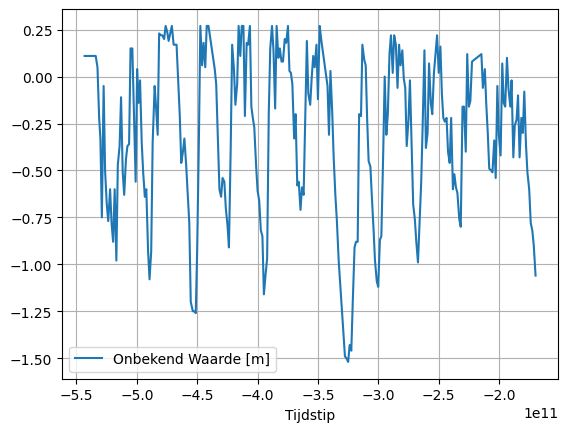

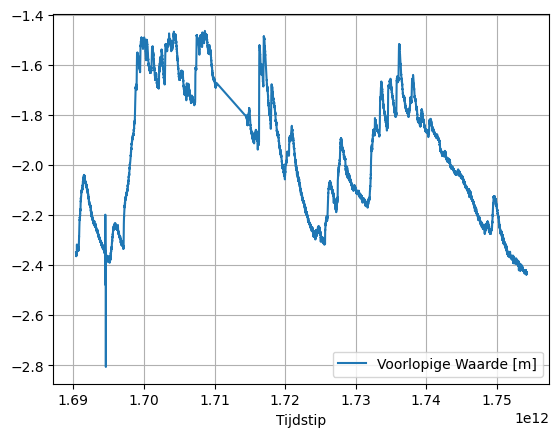

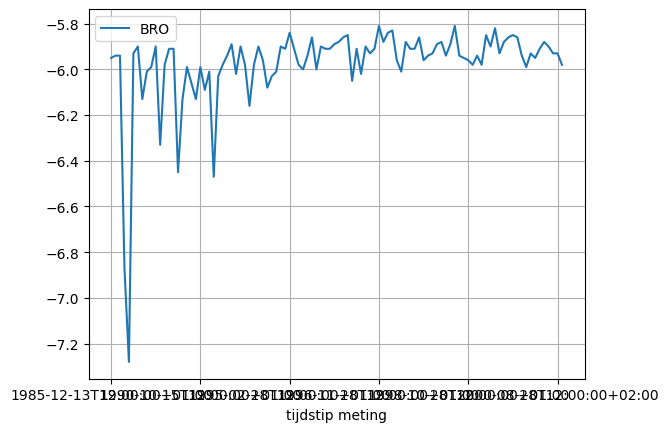

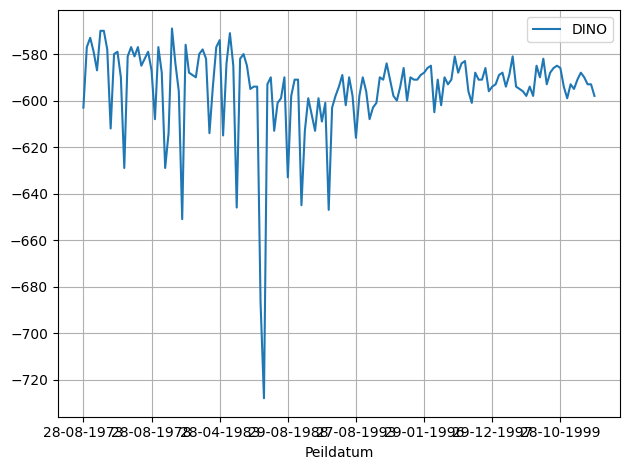

In [6]:
bro_1_df.plot(x='Tijdstip', y=bro_1_df.columns[1], kind='line', grid=True)
bro_2_df.plot(x='Tijdstip', y=bro_2_df.columns[1], kind='line', grid=True)
bro_0_df.plot(x='tijdstip meting', y='waterstand', kind='line', grid=True, label='BRO')
dino_df.plot(x='Peildatum', y='Stand (cm t.o.v NAP)', kind='line', grid=True, label='DINO')
plt.tight_layout()

## Normalization and standardization
We nomalize the data to make it comparable (in magnitude).
Additionally, the time-series do not have the same lenght nor the same sampling rate, nor the same date format. We convert all times to the same format (Unix) and store it in a separate dictionary times`.

In [11]:
# Normalization
s1 = bro_1_df[bro_1_df.columns[1]].values
s2 = bro_2_df[bro_2_df.columns[1]].values
s3 = dino_df['Stand (cm t.o.v NAP)'].values
s4 = bro_0_df['waterstand'].dropna().values
s1 = (s1 - np.mean(s1))/np.std(s1)
s2 = (s2 - np.mean(s2))/np.std(s2)
s3 = (s3 - np.mean(s3))/np.std(s3)
s4 = (s4 - np.mean(s4))/np.std(s4)
print(f"Mean bro_1: {np.mean(s1)}, std bro_1: {np.std(s1)}, length bro_1: {len(s1)}")
print(f"Mean bro_2: {np.mean(s2)}, std bro_2: {np.std(s2)}, length bro_2: {len(s2)}")
print(f"Mean dino: {np.mean(s3)}, std dino: {np.std(s3)}, length dino: {len(s3)}")
print(f"Mean bro_0: {np.mean(s4)}, std bro_0: {np.std(s4)}, length bro_0: {len(s4)}")

Mean bro_1: -1.3664283380001927e-17, std bro_1: 1.0, length bro_1: 260
Mean bro_2: 5.313430179366327e-16, std bro_2: 1.0, length bro_2: 16582
Mean dino: 1.5469597641134632e-15, std dino: 1.0, length dino: 151
Mean bro_0: -8.23969841158921e-15, std bro_0: 0.9999999999999998, length bro_0: 102


In [12]:
t1 = bro_1_df['Tijdstip'].values
t2 = bro_2_df['Tijdstip'].values
t3 = dino_df['Peildatum'].values
t4 = bro_0_df['tijdstip meting'].dropna().values

In [13]:
import re
def parse_date_to_unix(timestamps, default_tz='UTC'):
    """
    Convert ISO 8601 or date-only strings to Unix time (seconds since epoch).
    For date-only values, set time to midnight.
    
    Args:
        timestamps: list of strings (ISO or date-only)
        default_tz: timezone to assume if none provided, univ time is in UTC format
        dayfirst: interpret day-first for date-only formats like '28-08-1973' as given by BRO because we are in Europe.
    
    Returns:
        list of floats (Unix time in seconds)
    """
    _YFIRST = re.compile(r"^\d{4}[-/]\d{1,2}[-/]\d{1,2}")
    unix_times = []
    for ts in timestamps:
        if not isinstance(ts, str): 
            raise ValueError("Timestamps must be strings")
        ts = ts.strip()
        if not ts:
            unix_times.append(None)
            continue
        try:
            if _YFIRST.match(ts) or "T" in ts: # ISO & Y-first
                dt = pd.to_datetime(ts, utc=True)  
            else:  # Day-first branch
                dt = pd.to_datetime(ts, dayfirst=True)
            if dt.tzinfo is None:
                dt = dt.tz_localize(default_tz)
            unix_times.append(dt.timestamp())  # seconds since epoch
        except Exception:
            unix_times.append(None)
    return unix_times

In [14]:
times = {'s1': t1, 's2': t2, 's3': parse_date_to_unix(t3), 's4': parse_date_to_unix(t4)}
series = {'s1': s1, 's2': s2, 's3': s3, 's4': s4}

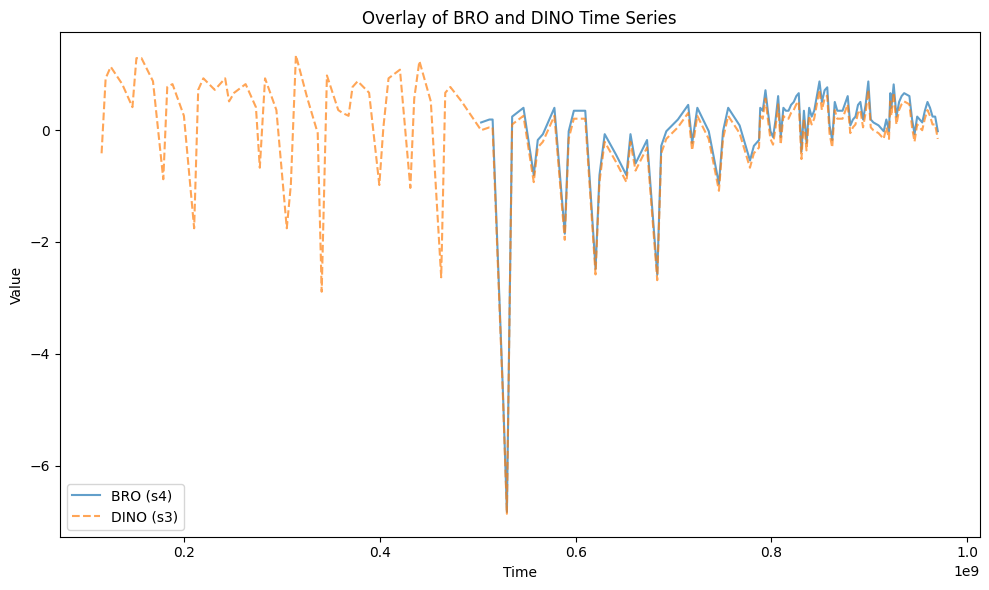

In [18]:
plt.figure(figsize=(10, 6))

plt.plot(times['s4'], s4, label='BRO (s4)', alpha=0.7)
plt.plot(times['s3'], s3, label='DINO (s3)', alpha=0.7, linestyle='--')

plt.xlabel("Time")
plt.ylabel("Value")
plt.title("Overlay of BRO and DINO Time Series")
plt.legend()
plt.tight_layout()
plt.show()

## Export data for use in other notebooks

In [ ]:
import pickle
# Export to a binary file using pickle
with open('../../data/4_time_series.pkl', 'wb') as f:
    pickle.dump({'times': times, 'series': series}, f)

## Example of importing the data

In [1]:
import pickle
with open('../../data/4_time_series.pkl', 'rb') as f:
    loaded_data = pickle.load(f)
times = loaded_data['times']
series = loaded_data['series']

## Test-dataset exploration

In [2]:
import pickle
with open(f"../../data/1188_sample_migrated_GLD_dino+bro.pkl", 'rb') as f:
    data = pickle.load(f)
meta_obs = data['meta']
data_obs = data['data']
print(len(meta_obs), len(data_obs))

1188 1188


In [ ]:
# Loop trough the data
for i, gld in enumerate(data_obs.keys()):
    dino_ts = data_obs[gld]['dino']
    bro_ts = data_obs[gld]['bro']
    # normalization
    dino_ts[:, 1] = (dino_ts[:, 1] - np.mean(dino_ts[:, 1])) / np.std(dino_ts[:, 1])
    bro_ts[:, 1] = (bro_ts[:, 1] - np.mean(bro_ts[:, 1])) / np.std(bro_ts[:, 1])

In [22]:
lengths = [len(data_obs[gld]['dino']) for gld in data_obs.keys()]
average_length = np.mean(lengths)
print(f"Average length of time series in test-dataset: {average_length}")

Average length of time series in test-dataset: 419.54882154882154
